<a href="https://colab.research.google.com/github/alexandreib/QuantDesign/blob/main/3_SP500_Portfolio_Alliocation_backtest_with_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Portfolio Optimization on S&P 500 Stocks Backtest with GBT predictions**


## **Introduction**
In the previous [notebook](https://medium.com/@alexandre.durand/portfolio-optimization-on-s-p-500-stocks-with-backtest-61da87ed91ff), we backtested 4 portfolio optiomization strategies :<br>
1. Random Allocation: Simple approach with no specific optimization for risk or return; often used as a baseline, but generally less efficient in managing return-risk trade-offs.<br>
2. Markowitz (Mean-Variance) Optimization: Balances return and risk by selecting asset weights based on expected returns and correlations, offering a robust strategy but highly dependent on accurate inputs.<br>
3. Minimum Variance: Prioritizes reducing overall portfolio risk without aiming for high returns, making it ideal for risk-averse investors; however, it may underperform in high-return environments.<br>
4. Sharpe Ratio Optimization: Focuses on maximizing risk-adjusted returns, providing a balanced approach between risk and return, but sensitive to the reliability of input data on returns and risk.<br><br>


We used the previous Quater results to generate our optimized weights.
<br><br>
In this notebook, we will run 2 Gradient Boost Tree, to estimate the next Quarter returns for the SP500 Stocks. <br>
Then we will rerun our backtest with the weighted optimized based on the predictions of the GBT.
<br><br>
Imports :


In [1]:
!pip install -q catboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import catboost, lightgbm
import sklearn
import sklearn.linear_model
import copy
import datetime as dt
import tqdm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## **Prepare Data**



In [3]:
df = pd.read_csv('/content/drive/MyDrive/QuantDesign/Articles/Portfolio Optimization/sp500_20years.csv')

# Calculate daily log returns
df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

# # Calculate quarterly log returns Using the first advantage of log Rturns : Tie Additivity
number_of_day_in_quarter = 63
df['Quarterly_Log_Return'] = df.groupby('Ticker')['Log_Return'].rolling(window=number_of_day_in_quarter, min_periods=number_of_day_in_quarter).sum().reset_index(0, drop=True)

df['target'] = df['Quarterly_Log_Return'].shift(-number_of_day_in_quarter)
df.head(2)

,Date,Ticker,Adj Close,Log_Return,Quarterly_Log_Return,target
0,2004-11-22,MMM,37.598114,NaN,NaN,0.043639
1,2004-11-23,MMM,37.365273,-0.006212,NaN,0.054013


## Features Creation

In [4]:
# days before rebalancing :
days = [10, 20, 63]

# Calculate Daily Features :
# Calculate RSI (Relative Strength Index)
delta = df.groupby('Ticker')['Adj Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df.loc[:, 'RSI'] = 100 - (100 / (1 + rs))

# Calculate MACD (Moving Average Convergence Divergence)
EMA12 = df.groupby('Ticker', group_keys = False)['Adj Close'].apply(lambda x: x.ewm(span=12).mean())
EMA26 = df.groupby('Ticker', group_keys = False)['Adj Close'].apply(lambda x: x.ewm(span=26).mean())
df.loc[:, 'MACD'] = EMA12 - EMA26
df.loc[:, 'Signal_Line'] = df.groupby('Ticker', group_keys = False)['MACD'].apply(lambda x: x.ewm(span=9, adjust=False).mean())

# Calculate cumsum
df = df.assign(change_sign_cumsum = (np.sign(df.Log_Return) != np.sign(df.Log_Return.shift())).cumsum())
df['change_sign_cumsum'] = df.groupby('change_sign_cumsum')['Log_Return'].cumsum()

# Calculate Daily Informations
for col in ['Log_Return', 'Quarterly_Log_Return'] :
    df.loc[:, f'Date_{col}_std'] = df['Date'].map(df.groupby('Date', group_keys = False)[col].std())
    df.loc[:, f'Date_{col}_mean'] = df['Date'].map(df.groupby('Date', group_keys = False)[col].mean())
    df.loc[:, f'Date_{col}_min'] = df['Date'].map(df.groupby('Date', group_keys = False)[col].min())
    df.loc[:, f'Date_{col}_max'] = df['Date'].map(df.groupby('Date', group_keys = False)[col].max())

for col in ['Log_Return', 'Quarterly_Log_Return'] :
    df.loc[:, f'zscore_{col}'] = (df['Log_Return'] - df[f'Date_{col}_mean']) / df[f'Date_{col}_std']

# Calculate Quaterly Infos
for day in days :
    for col in ['Date_Log_Return_mean', 'Log_Return', 'change_sign_cumsum', 'zscore_Log_Return','zscore_Quarterly_Log_Return', 'Quarterly_Log_Return'] :
        df.loc[:, f'Quarter_{col}_{day}_Min'] = df.groupby('Ticker', group_keys = False)[col].apply(lambda x: x.rolling(window=day, min_periods=day).min())
        df.loc[:, f'Quarter_{col}_{day}_Max'] = df.groupby('Ticker', group_keys = False)[col].apply(lambda x: x.rolling(window=day, min_periods=day).max())
        df.loc[:, f'Quarter_{col}_{day}_Mean'] = df.groupby('Ticker', group_keys = False)[col].apply(lambda x: x.rolling(window=day, min_periods=day).mean())
        df.loc[:, f'Quarter_{col}_{day}_Std'] = df.groupby('Ticker', group_keys = False)[col].apply(lambda x: x.rolling(window=day, min_periods=day).std())
        df.loc[:, f'Quarter_{col}_{day}_Sum'] = df.groupby('Ticker', group_keys = False)[col].apply(lambda x: x.rolling(window=day, min_periods=day).sum())

df = df.dropna(subset = ['target'])
df.tail(1)

<ipython-input-4-2995823282>:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, f'Quarter_{col}_{day}_Mean'] = df.groupby('Ticker', group_keys = False)[col].apply(lambda x: x.rolling(window=day, min_periods=day).mean())
<ipython-input-4-2995823282>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, f'Quarter_{col}_{day}_Std'] = df.groupby('Ticker', group_keys = False)[col].apply(lambda x: x.rolling(window=day, min_periods=day).std())
<ipython-input-4-2995823282>:41: PerformanceWarning: DataFrame is highly fragm

,Date,Ticker,Adj Close,Log_Return,Quarterly_Log_Return,target,RSI,MACD,Signal_Line,change_sign_cumsum,...,Quarter_zscore_Quarterly_Log_Return_63_Min,Quarter_zscore_Quarterly_Log_Return_63_Max,Quarter_zscore_Quarterly_Log_Return_63_Mean,Quarter_zscore_Quarterly_Log_Return_63_Std,Quarter_zscore_Quarterly_Log_Return_63_Sum,Quarter_Quarterly_Log_Return_63_Min,Quarter_Quarterly_Log_Return_63_Max,Quarter_Quarterly_Log_Return_63_Mean,Quarter_Quarterly_Log_Return_63_Std,Quarter_Quarterly_Log_Return_63_Sum
2530026,2024-08-16,ZTS,183.275711,-0.002012,0.058347,-0.048322,52.269445,2.143013,2.286867,-0.002012,...,-0.672587,0.481974,-0.113491,0.257307,-7.149943,-0.154677,0.21252,0.040291,0.100281,2.538352


## Label Encoders for the tickers

In [5]:
LabelEncoder =  { x : i for i, x in enumerate(df['Ticker'].unique())}
LabelDecoder =  { v : k for k, v in LabelEncoder.items()}
df['Ticker'] = df['Ticker'].map(LabelEncoder)


## Split DataFrame

To backtest our portfolio optimization, we will split on dataframe.
<br><br>
We will use the date columns ot split the data :<br>
- Train dataframe : We will use to train the Machine Learninbg Algorithms (GBT).<br>
- Valid dataframe : We will the valid dataframe, to measure the results of the machine learning algortihtms (GBT), detect overfitt, and to calculate the Covariance Matrice.<br>
- Test dataframe : used for the Backtest.<br>
<br>

For the test dataset we keep 1 rebalancing every 63 days.<br>
We don't do the same for train and valid dataset, on the assumption that more data will help the GBT models, and keep unbiased estiamtes.<br>

In [6]:
dates = list(df['Date'].unique())

dates_train = dates[:int(len(dates) * 0.8)]
dates_valid = dates[int(len(dates) * 0.8) : int(len(dates) * 0.90)]
dates_test = dates[int(len(dates) * 0.90):][0::number_of_day_in_quarter] ## Keep 1 rebalancing very 63 days

train = df[df['Date'].isin(dates_train)]
valid = df[df['Date'].isin(dates_valid)]
test = df[df['Date'].isin(dates_test)]
display(test.head(2))

print(f"train : {len(train)} : {train['Date'].min()} -> {train['Date'].max()}")
print(f"valid : {len(valid)} : {valid['Date'].min()} -> {valid['Date'].max()}")
print(f"test : {len(test)} : {test['Date'].min()} -> {test['Date'].max()}")

l_features = [col for col in train.columns if col not in ['Date', 'Adj Close', 'target']]

Y_train = train['target'].values
Y_valid = valid['target'].values
Y_test = test['target'].values

del df

train = train.fillna(train[l_features].mean())
valid = valid.fillna(train[l_features].mean())
test = test.fillna(train[l_features].mean())

,Date,Ticker,Adj Close,Log_Return,Quarterly_Log_Return,target,RSI,MACD,Signal_Line,change_sign_cumsum,...,Quarter_zscore_Quarterly_Log_Return_63_Min,Quarter_zscore_Quarterly_Log_Return_63_Max,Quarter_zscore_Quarterly_Log_Return_63_Mean,Quarter_zscore_Quarterly_Log_Return_63_Std,Quarter_zscore_Quarterly_Log_Return_63_Sum,Quarter_Quarterly_Log_Return_63_Min,Quarter_Quarterly_Log_Return_63_Max,Quarter_Quarterly_Log_Return_63_Mean,Quarter_Quarterly_Log_Return_63_Std,Quarter_Quarterly_Log_Return_63_Sum
4471,2022-08-26,0,97.788216,-0.100268,-0.119598,0.010867,20.596366,0.216459,1.652126,-0.100268,...,-0.809462,1.184724,0.414381,0.631647,26.106031,-0.148588,0.040938,-0.056408,0.062738,-3.553692
4534,2022-11-25,0,98.856644,0.008092,0.010867,-0.167248,64.180650,2.113502,2.177390,0.008092,...,-0.735870,0.642972,0.165603,0.316405,10.433000,-0.216085,0.010867,-0.135163,0.033792,-8.515279


train : 1782103 : 2004-11-22 -> 2020-09-03
valid : 245089 : 2020-09-04 -> 2022-08-25
test : 3968 : 2022-08-26 -> 2024-05-30


## Lightgbm Train and Predict on Valid data

In [7]:
model_lightgbm = lightgbm.LGBMRegressor(n_estimators = 1_000,
                                verbose = 1,
                                random_state = 42
                                ).fit(train[l_features], Y_train,
                                    categorical_feature = ['Ticker'],
                                    eval_set=[(valid[l_features], Y_valid)],
                                    eval_metric = 'rmse',
                                    callbacks=[lightgbm.callback.early_stopping(20), lightgbm.callback.log_evaluation(10)]
                                    )

valid['pred_lightgbm'] = model_lightgbm.predict(valid[l_features])
valid['error_lightgbm'] = valid['pred_lightgbm'] - Y_valid

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.373832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27283
[LightGBM] [Info] Number of data points in the train set: 1782103, number of used features: 107
[LightGBM] [Info] Start training from score 0.027143
Training until validation scores don't improve for 20 rounds
[10]	valid_0's rmse: 0.155762	valid_0's l2: 0.0242619
[20]	valid_0's rmse: 0.159182	valid_0's l2: 0.025339
Early stopping, best iteration is:
[2]	valid_0's rmse: 0.150967	valid_0's l2: 0.0227911


<ipython-input-7-749673210>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid['pred_lightgbm'] = model_lightgbm.predict(valid[l_features])
<ipython-input-7-749673210>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid['error_lightgbm'] = valid['pred_lightgbm'] - Y_valid


## Catboost Train and Predict on Valid data

In [8]:
model_catboost = catboost.CatBoostRegressor(iterations = 1_000,
                                   random_seed = 42
                                   ).fit(train[l_features], Y_train,
                                        cat_features = ['Ticker'],
                                        eval_set=(valid[l_features], Y_valid),
                                        early_stopping_rounds = 20,
                                        verbose = 10
                                   )


valid['pred_catboost'] = model_catboost.predict(valid[l_features])
valid['error_catboost'] = valid['pred_catboost'] - Y_valid

Learning rate set to 0.164927
0:	learn: 0.1584164	test: 0.1549999	best: 0.1549999 (0)	total: 1.96s	remaining: 32m 33s
10:	learn: 0.1456208	test: 0.1566287	best: 0.1549999 (0)	total: 19.1s	remaining: 28m 35s
20:	learn: 0.1408578	test: 0.1572810	best: 0.1549999 (0)	total: 33.4s	remaining: 25m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1549998862
bestIteration = 0

Shrink model to first 1 iterations.


<ipython-input-8-1964654450>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid['pred_catboost'] = model_catboost.predict(valid[l_features])
<ipython-input-8-1964654450>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid['error_catboost'] = valid['pred_catboost'] - Y_valid


## Simple Ensemble witrh weighted mean

In [9]:
model_ensemble = sklearn.linear_model.LinearRegression(positive = True, fit_intercept = False)
l_features_ensemble = ['pred_catboost', 'pred_lightgbm']
model_ensemble.fit(valid[l_features_ensemble], Y_valid)
weights_models = model_ensemble.coef_/model_ensemble.coef_.sum() ## Create <1 coefficients.

valid['pred_ensemble'] = (weights_models * valid[l_features_ensemble]).sum(axis = 1)
valid['error_ensemble'] = valid['pred_ensemble'] - Y_valid

print(weights_models)

[0. 1.]


<ipython-input-9-3371097982>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid['pred_ensemble'] = (weights_models * valid[l_features_ensemble]).sum(axis = 1)
<ipython-input-9-3371097982>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid['error_ensemble'] = valid['pred_ensemble'] - Y_valid


We will create a reference error, which is based ont the previous Quarter returns. <br>
Similar estimates than what we used in the previous notebook.

In [10]:
valid['pred_reference'] = valid['Quarterly_Log_Return']
valid['error_reference'] = valid['pred_reference'] - Y_valid

<ipython-input-10-3620397769>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid['pred_reference'] = valid['Quarterly_Log_Return']
<ipython-input-10-3620397769>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid['error_reference'] = valid['pred_reference'] - Y_valid


Calculate the RMSE (Root Mean Square Error) of the different models :

In [11]:
l_preds = ['pred_reference', 'pred_catboost', 'pred_lightgbm', 'pred_ensemble']
l_erros = ['error_reference', 'error_catboost', 'error_lightgbm', 'error_ensemble']

In [12]:
for errors in l_erros :
    RMSE = np.sqrt(np.mean((valid[errors]**2)))
    print(f'RMSE {errors} : {RMSE:.3f}')

RMSE error_reference : 0.203
RMSE error_catboost : 0.155
RMSE error_lightgbm : 0.151
RMSE error_ensemble : 0.151


We can clearly observe that the RMSE is the minimum for the ensemble betwwen catboost and lgbm.

The Ensemble model brings a very importante deacrease of the Error (will that be enough to generate improvement of the returns once we run the portfolio optimization strategies).

In [13]:
# ax = sns.scatterplot(valid.melt(id_vars = 'target', value_vars = l_preds).rename(columns ={'value' : 'prediction', 'variable' : 'model'}),
#                      x = 'target', y = 'prediction', hue = 'model', sizes = 0.1)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.show()

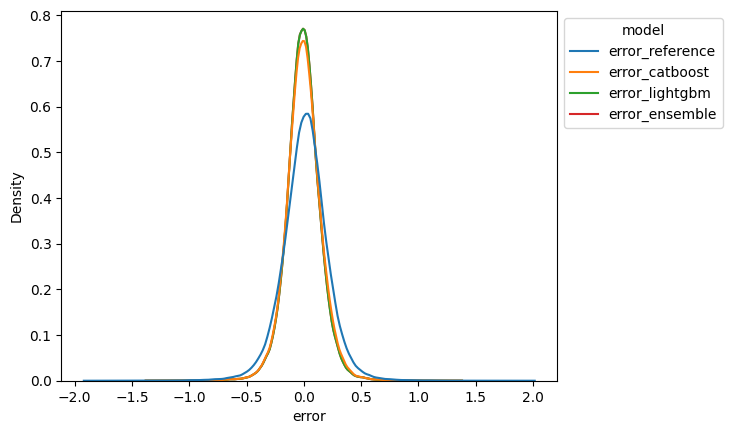

In [14]:
ax = sns.kdeplot(data = valid.melt(id_vars = 'target', value_vars = l_erros).rename(columns ={'value' : 'error', 'variable' : 'model'}),
                 x = 'error', hue = 'model')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

With the graph, we can observer that errors seems to have a mean around 0. <br>
Except the reference model.

Let calculate the acutual values for the mean and variance of the errors :

In [15]:
l_cols_ensemble = [col for col in valid if 'error_' in col]

valid[l_cols_ensemble].describe()

,error_lightgbm,error_catboost,error_ensemble,error_reference
count,245089.000000,245089.000000,245089.000000,245089.000000
mean,-0.003889,-0.001407,-0.003889,0.011745
std,0.150918,0.154994,0.150918,0.202618
min,-1.342477,-1.340154,-1.342477,-1.869519
25%,-0.092077,-0.093328,-0.092077,-0.103669
50%,-0.005221,-0.003659,-0.005221,0.014775
75%,0.083211,0.088872,0.083211,0.129560
max,1.343024,1.336639,1.343024,1.964533


Errors means are not exactly at 0, but slightly negative. <br>
We can interpret that as negative skewed dataset can pull the model to a slightly negative error mean.
The negative skewed dataset (log returns), could probably be explains by high volatility days, creating negative logs returns outliers.
 <br> <br>
We could in future model try to modify the log return distribution to improve our model prediction and reduce error mean.


## Test Prediction

Use the 2 models, plus the ensemble model to predict our next quarter returns.

In [16]:
test['pred_lightgbm'] = model_lightgbm.predict(test[l_features])
test['error_lightgbm'] = test['pred_lightgbm'] - Y_test

test['pred_catboost'] = model_catboost.predict(test[l_features])
test['error_catboost'] = test['pred_catboost'] - Y_test

test['pred_ensemble'] = (weights_models * test[l_features_ensemble]).sum(axis = 1)
test['error_ensemble'] = test['pred_ensemble'] - Y_test

test['pred_reference'] = test['Quarterly_Log_Return']
test['error_reference'] = test['pred_reference'] - Y_test

test[l_cols_ensemble].describe()

<ipython-input-16-4249291013>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['pred_lightgbm'] = model_lightgbm.predict(test[l_features])
<ipython-input-16-4249291013>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['error_lightgbm'] = test['pred_lightgbm'] - Y_test
<ipython-input-16-4249291013>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To ge

,error_lightgbm,error_catboost,error_ensemble,error_reference
count,3968.000000,3968.000000,3968.000000,3968.000000
mean,0.000159,0.000465,0.000159,-0.009113
std,0.135348,0.133130,0.135348,0.195744
min,-1.081143,-1.075777,-1.081143,-1.378825
25%,-0.082901,-0.081564,-0.082901,-0.128509
50%,0.000204,-0.000600,0.000204,-0.011860
75%,0.080163,0.076864,0.080163,0.106784
max,0.914335,0.921328,0.914335,1.165207


In [17]:
for errors in l_erros :
    RMSE = np.sqrt(np.mean((test[errors]**2)))
    print(f'RMSE {errors} : {RMSE:.3f}')

RMSE error_reference : 0.196
RMSE error_catboost : 0.133
RMSE error_lightgbm : 0.135
RMSE error_ensemble : 0.135


Decode the Ticker back to Symbols.

In [18]:
test['Ticker'] = test['Ticker'].map(LabelDecoder)
valid['Ticker'] = valid['Ticker'].map(LabelDecoder)

Calculate Covariance Matrice on the valid dataset

In [19]:
def calculate_shrink_cov_matrix (df) :
    masked_arr = np.ma.array(df, mask=np.isnan(df))
    cov_numpy = np.ma.cov(masked_arr, rowvar=False, allow_masked=True, ddof=1).data
    n_samples, n_features = df.shape
    alpha = np.mean(cov_numpy**2)
    mu = np.trace(cov_numpy) / n_features
    mu_squared = mu**2
    num = alpha + mu_squared
    den = (n_samples + 1) * (alpha - mu_squared / n_features)
    shrinkage = 1.0 if den == 0 else min(num / den, 1.0)
    shrunk_cov = (1.0 - shrinkage) * cov_numpy
    shrunk_cov.flat[:: n_features + 1] += shrinkage * mu
    return shrunk_cov

# Creation of the log return Matrix
pivot_returns_valid = valid.pivot_table(values='Quarterly_Log_Return', columns='Ticker', index = 'Date')\
                         .fillna(0)

matrix_covariance = calculate_shrink_cov_matrix(pivot_returns_valid)
matrix_covariance = pd.DataFrame(matrix_covariance, columns = pivot_returns_valid.columns, index = pivot_returns_valid.columns)
matrix_covariance.head(1)

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Ticker,,,,,,,,,,,,,,,,,,,,,
A,0.015297,0.006963,-0.003078,0.006746,0.005863,0.000766,0.009671,0.016227,0.007999,-0.003437,...,0.001968,0.001581,0.008896,-0.002047,-0.006113,0.017819,0.006926,0.004852,0.020861,0.009472


Declaration of the functions to optimize the portfolio (see previous [notebooks](https://medium.com/@alexandre.durand/portfolio-optimisation-on-s-p-500-stocks-46f03732b030) for more explanations).


In [20]:
def calculate_portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def calculate_portfolio_returns(weights, returns):
    return np.dot(weights, returns)

def variance_objective(weights, cov_matrix):
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return portfolio_variance

### Using Negative Markowitz Objective, as we will use scipy.optimize.minimize
def neg_markowitz_objective(weights, returns, cov_matrix, gamma = 0.1):
    portfolio_returns = np.squeeze(calculate_portfolio_returns(weights, returns))
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return gamma * portfolio_variance - portfolio_returns

### Using Negative Sharpe Ratio, as we will use scipy.optimize.minimize
def neg_sharpe_ratio_objective(weights, returns, cov_matrix, risk_free_rate = 0.03):
    portfolio_returns = np.squeeze(calculate_portfolio_returns(weights, returns))
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return -((portfolio_returns - risk_free_rate)/np.sqrt(portfolio_variance))

### Generic Optimize weights functions
def optimize_weights(log_returns, covariance_matrix, fun=neg_markowitz_objective, x0 = None):
    number_of_tickers = len(log_returns)
    if x0 == None : x0 = np.array([1/number_of_tickers for _ in range(number_of_tickers)])
    if fun == calculate_portfolio_variance : args = (covariance_matrix)
    else : args = (log_returns, covariance_matrix)
    result = sp.optimize.minimize(fun = fun,
                                args = args,
                                x0 = x0,
                                method = 'SLSQP',
                                bounds = tuple((0, 0.3) for _ in range(number_of_tickers)),## we don't want to have more than 30% of the portfolio on 1 asset
                                constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
                                )
    return result.x

## Backtest loop

In [21]:
results = {}
for date in tqdm.tqdm(test.Date.unique()):
    results[date] = {}

for preds in ['pred_catboost', 'pred_lightgbm', 'pred_ensemble', 'pred_reference'] : #adding loop for each prediction
    print(preds)
    for date in tqdm.tqdm(test.Date.unique()):
        tickers = test[test.Date == date].Ticker.values
        tickers_returns_future = test[test.Date == date].target # This Quarter returns
        tickers_returns_pred = test[test.Date == date][preds]

        # Create Masks to keep only : Prediction > 0
        mask_preds_positives = tickers_returns_pred.values > 0
        # Create Masks to keep only : Tickers in the covariance Matrice ( calculated on Valid Data)
        mask_tickers_in_covariance_matrice = [True if col in matrix_covariance.columns else False for col in tickers]
        mask = mask_preds_positives & mask_tickers_in_covariance_matrice

        # Filtered Tickers, predictions, and real returns
        tickers = tickers[mask]
        tickers_returns_future = tickers_returns_future[mask]
        tickers_returns_pred = tickers_returns_pred[mask]
        matrix_covariance_filtered = matrix_covariance.loc[tickers, tickers]

        # Creating default weights for 3 types of portfolio potimized
        weights_sharpe = optimize_weights(tickers_returns_pred, matrix_covariance_filtered, fun = neg_sharpe_ratio_objective)
        results[date][f'returns_sharpe_{preds}'] = (weights_sharpe * tickers_returns_future).sum()

        weights_min_variance= optimize_weights(tickers_returns_pred, matrix_covariance_filtered, fun = calculate_portfolio_variance)
        results[date][f'returns_min_variance_{preds}'] =  (weights_min_variance * tickers_returns_future).sum()

        weights_mean_min_variance = optimize_weights(tickers_returns_pred, matrix_covariance_filtered, fun = neg_markowitz_objective)
        results[date][f'returns_markowitz_{preds}'] =  (weights_mean_min_variance * tickers_returns_future).sum()

100%|██████████| 8/8 [00:00<00:00, 48210.39it/s]


pred_catboost


100%|██████████| 8/8 [07:41<00:00, 57.66s/it]


pred_lightgbm


100%|██████████| 8/8 [08:05<00:00, 60.75s/it]


pred_ensemble


100%|██████████| 8/8 [08:03<00:00, 60.38s/it]


pred_reference


100%|██████████| 8/8 [01:55<00:00, 14.42s/it]


## Results

In [22]:
df = pd.DataFrame(results).T
df.columns

Index(['returns_sharpe_pred_catboost', 'returns_min_variance_pred_catboost',
       'returns_markowitz_pred_catboost', 'returns_sharpe_pred_lightgbm',
       'returns_min_variance_pred_lightgbm', 'returns_markowitz_pred_lightgbm',
       'returns_sharpe_pred_ensemble', 'returns_min_variance_pred_ensemble',
       'returns_markowitz_pred_ensemble', 'returns_sharpe_pred_reference',
       'returns_min_variance_pred_reference',
       'returns_markowitz_pred_reference'],
      dtype='object')

In [23]:
l_min_variance_columns = [x for x in df.columns if 'min_variance' in x]
l_sharpe_columns = [x for x in df.columns if 'sharpe' in x]
l_markowitz_columns = [x for x in df.columns if 'markowitz' in x]

l_returns_columns = [x for x in df.columns if 'returns' in x]

<ipython-input-34-3077318227>:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.3))
<ipython-input-34-3077318227>:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.3))
<ipython-input-34-3077318227>:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend(title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.3))


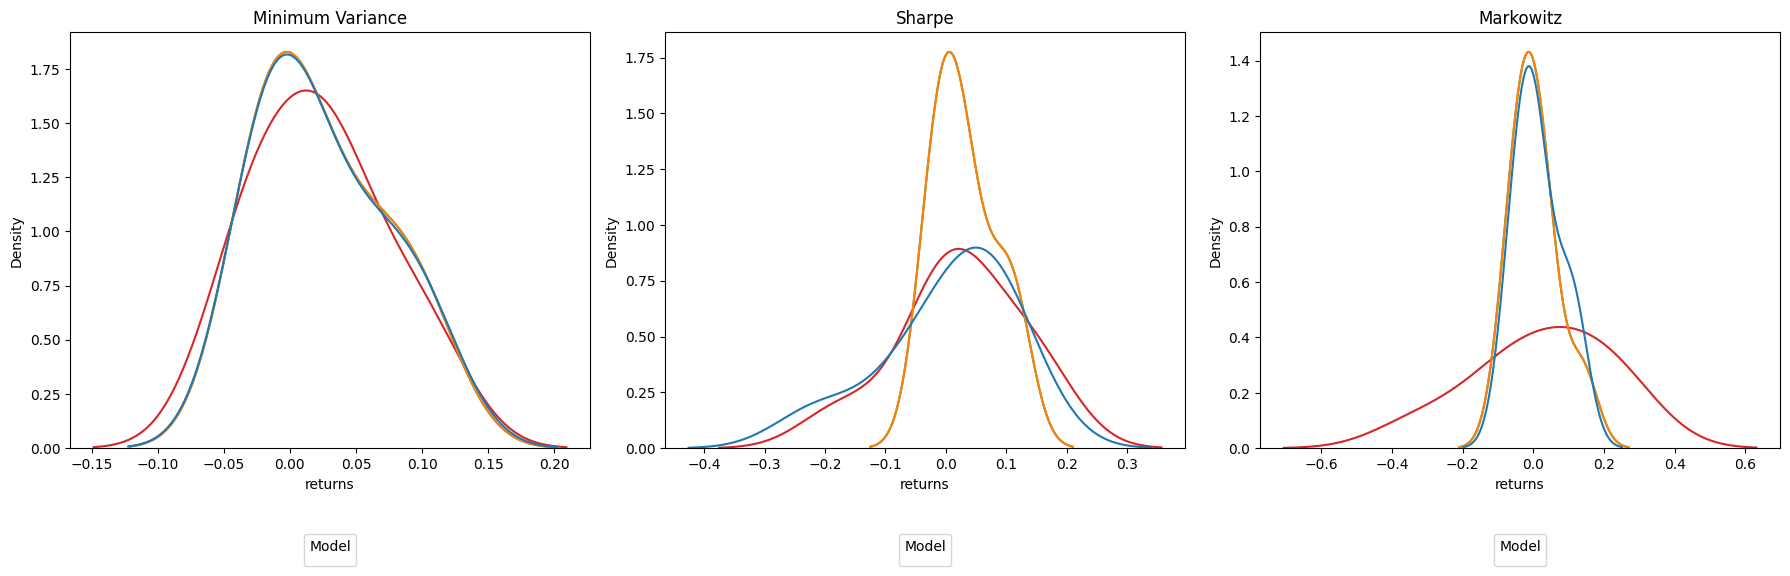

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1
sns.kdeplot(data = df[l_min_variance_columns].melt(value_name = 'returns', var_name = 'model'),
                 x = 'returns', hue = 'model', ax=axes[0])
axes[0].set_title('Minimum Variance')
axes[0].legend(title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.3))

# Plot 2
sns.kdeplot(data = df[l_sharpe_columns].melt(value_name = 'returns', var_name = 'model'),
                 x = 'returns', hue = 'model', ax=axes[1])
axes[1].set_title('Sharpe')
axes[1].legend(title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.3))

# Plot 3
sns.kdeplot(data = df[l_markowitz_columns].melt(value_name = 'returns', var_name = 'model'),
                 x = 'returns', hue = 'model', ax=axes[2])
axes[2].set_title('Markowitz')
axes[2].legend(title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.3))

plt.tight_layout()
plt.show()


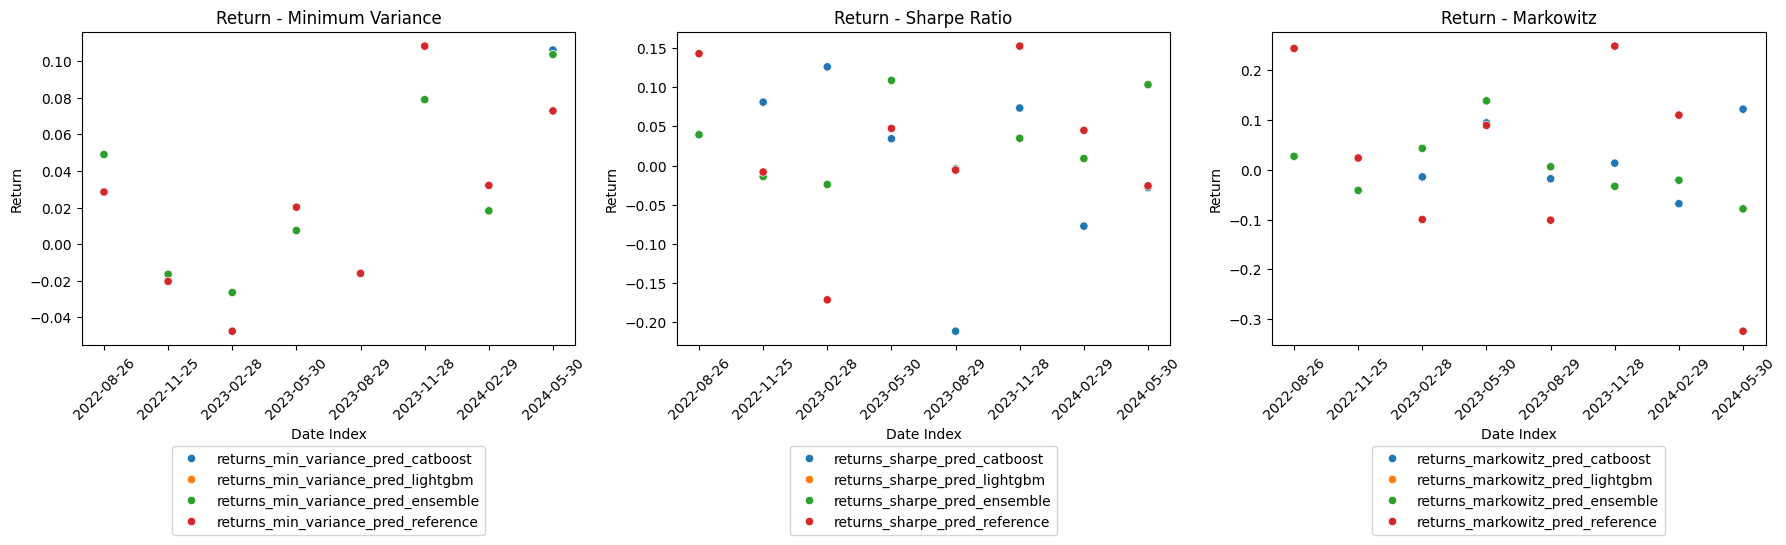

In [25]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
# Plot Minimum Variance
sns.scatterplot(data=df[l_min_variance_columns].reset_index().melt(id_vars='index', value_name='Return', var_name='Model'),
             x='index', y='Return', hue='Model', ax=axes[0])
axes[0].set_title('Return - Minimum Variance')
axes[0].set_xlabel('Date Index')
axes[0].set_ylabel('Return')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3))
# Plot Sharpe Ratio
sns.scatterplot(data=df[l_sharpe_columns].reset_index().melt(id_vars='index', value_name='Return', var_name='Model'),
             x='index', y='Return', hue='Model', ax=axes[1])
axes[1].set_title('Return - Sharpe Ratio')
axes[1].set_xlabel('Date Index')
axes[1].set_ylabel('Return')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3))
# Plot Markowitz
sns.scatterplot(data=df[l_markowitz_columns].reset_index().melt(id_vars='index', value_name='Return', var_name='Model'),
             x='index', y='Return', hue='Model', ax=axes[2])
axes[2].set_title('Return - Markowitz')
axes[2].set_xlabel('Date Index')
axes[2].set_ylabel('Return')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3))
plt.tight_layout()
plt.show()

In [26]:
l_min_variance_columns_cumsum = [x + '_cumsum' for x in l_min_variance_columns]
l_sharpe_columns_cumsum = [x + '_cumsum' for x in l_sharpe_columns]
l_markowitz_columns_cumsum = [x + '_cumsum' for x in l_markowitz_columns]

df[l_min_variance_columns_cumsum] = df[l_min_variance_columns].cumsum()
df[l_sharpe_columns_cumsum] = df[l_sharpe_columns].cumsum()
df[l_markowitz_columns_cumsum] = df[l_markowitz_columns].cumsum()


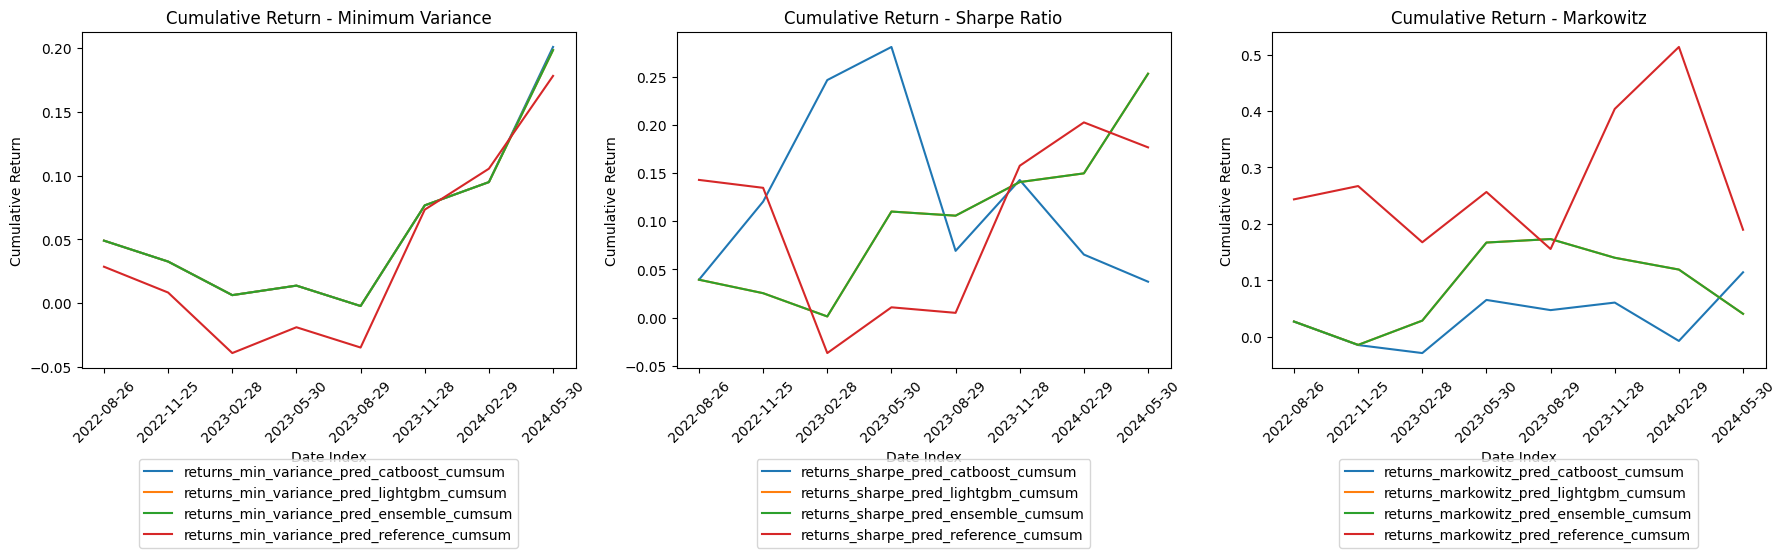

In [27]:
# prompt: plot 3graph  in line with legend in column bellow each graph, l_min_variance_columns_cumsum, l_sharpe_columns_cumsum, l_markowitz_columns_cumsum, x axis index, x legend 45degree

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Plot Minimum Variance
sns.lineplot(data=df[l_min_variance_columns_cumsum].reset_index().melt(id_vars='index', value_name='Cumulative Return', var_name='Model'),
             x='index', y='Cumulative Return', hue='Model', ax=axes[0])
axes[0].set_title('Cumulative Return - Minimum Variance')
axes[0].set_xlabel('Date Index')
axes[0].set_ylabel('Cumulative Return')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))


# Plot Sharpe Ratio
sns.lineplot(data=df[l_sharpe_columns_cumsum].reset_index().melt(id_vars='index', value_name='Cumulative Return', var_name='Model'),
             x='index', y='Cumulative Return', hue='Model', ax=axes[1])
axes[1].set_title('Cumulative Return - Sharpe Ratio')
axes[1].set_xlabel('Date Index')
axes[1].set_ylabel('Cumulative Return')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

# Plot Markowitz
sns.lineplot(data=df[l_markowitz_columns_cumsum].reset_index().melt(id_vars='index', value_name='Cumulative Return', var_name='Model'),
             x='index', y='Cumulative Return', hue='Model', ax=axes[2])
axes[2].set_title('Cumulative Return - Markowitz')
axes[2].set_xlabel('Date Index')
axes[2].set_ylabel('Cumulative Return')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))


plt.tight_layout()
plt.show()


In [28]:
df[l_returns_columns].sum().sort_values(ascending = False)

,0
returns_sharpe_pred_lightgbm,0.252975
returns_sharpe_pred_ensemble,0.252975
returns_min_variance_pred_catboost,0.200994
returns_min_variance_pred_lightgbm,0.198541
returns_min_variance_pred_ensemble,0.198541
returns_markowitz_pred_reference,0.189692
returns_min_variance_pred_reference,0.178275
returns_sharpe_pred_reference,0.176616
returns_markowitz_pred_catboost,0.114281
returns_markowitz_pred_lightgbm,0.040701



## **Conclusion**

The cumulative returns plots (using the _cumsum columns) show that for each portfolio optimization strategy (Minimum Variance, Sharpe Ratio, and Markowitz), the portfolios optimized using the predictions from the machine learning models (CatBoost, LightGBM, and their Ensemble) **consistently outperformed** the portfolio optimized using the "reference" prediction (which is based on the previous quarter's return).



**Specifically:**

Minimum Variance: The cumulative returns for portfolios using ML predictions are higher than the reference portfolio.
Sharpe Ratio: The cumulative returns for portfolios using ML predictions are higher than the reference portfolio.

Markowitz: The cumulative returns for portfolios using ML predictions are higher than the reference portfolio.
While the Kernel Density Estimation (KDE) plots and scatter plots of individual quarter returns provide insights into the distribution and variability of returns, the cumulative return plot provides the most direct evidence of long-term performance. The upward trend of the ML-based portfolios compared to the reference portfolio clearly demonstrates their superior performance over the backtesting period for all three optimization strategies.

**Therefore, it can be concluded that incorporating machine learning model predictions for future returns leads to improved performance across all tested portfolio optimization strategies compared to using historical returns as a prediction.**